In [53]:
%matplotlib notebook

In [55]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from scipy import stats
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u
from sbpy.photometry import HG, HG1G2, HG12, HG12_Pen16
from scipy.optimize import curve_fit

In [4]:
sys.path.append("/Users/jrobinson/atlas-phase-curves/atlas-phase-curves")
from calculate_phase import atlas_SQL_query_df
from calculate_phase import atlas_database_connection
from calculate_phase import solar_apparitions as sa

In [5]:
# sys.path.append("/home/astro/atlas-phase-curves/atlas-phase-curves/tools")
sys.path.append("/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/tools")
import database_tools as dbt
import importlib

In [6]:
importlib.reload(dbt)
importlib.reload(atlas_SQL_query_df)

<module 'calculate_phase.atlas_SQL_query_df' from '/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/calculate_phase/atlas_SQL_query_df.py'>

In [7]:
# name = "Osipovia"
# mpc_number = 4986

# name = "Fitzsimmons"
# name = "Moguntia"
# name = "1997 YU10" # need a minimum number of data points per epoch
# name = "Aidamina" # need a minimum phase angle requirement
# name = "Cerberus" # large rotational variation
name = "Patroclus"
mpc_number = False

In [8]:
# # data_file = "/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/results_analysis/obs/df_data_{}.csv".format(mpc_number)
# data_file = "/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/results_analysis/obs/df_data_{}.csv".format(name)
# df_data_filt = pd.read_csv(data_file,index_col = 0)
# df_data_filt

In [9]:
# connect to database
cnx=atlas_database_connection.database_connection().connect()

In [10]:
orbid=atlas_SQL_query_df.get_orb_elements_id(cnx,mpc_number,name)
df_data_filt=atlas_SQL_query_df.atlas_SQL_query_orbid_expname(cnx,orbid)
df_data = df_data_filt

mpc_number=False
name=Patroclus
orbital_elements_id=617


In [11]:
df_HG = atlas_SQL_query_df.get_astorb_HG(cnx,orbid)
df_HG

,name,mpc_number,G_slope,H_abs_mag,H_abs_mag_o,H_abs_mag_c
0,Patroclus,617,0.15,8.23,7.898,8.284


In [12]:
df_data_filt = df_data_filt.sort_values("mjd")

In [13]:
df_data_filt

,expname,dec_deg,ra_deg,mjd,m,merr,filter,observer_distance,heliocentric_distance,phase_angle,reduced_mag,apparent_mag,galactic_latitude,sun_obs_target_angle,orbfit_separation_arcsec
36,02a57384o0411o,45.485340,118.233314,57384.475197,15.278,0.352,o,4.578003,5.464336,4.8817,8.286933,15.595,29.3782,151.7728,1.729743
37,02a57385o0449o,45.545569,118.066688,57385.492674,15.231,0.019,o,4.575300,5.465290,4.7938,8.240836,15.590,29.2737,152.3181,0.141852
38,02a57386o0382o,45.599350,117.912478,57386.424028,15.216,0.017,o,4.573085,5.466163,4.7180,8.226541,15.585,29.1769,152.7858,0.172915
42,02a57386o0396o,45.599860,117.910971,57386.432836,15.215,0.021,o,4.573065,5.466171,4.7173,8.225547,15.585,29.1759,152.7902,0.151762
40,02a57386o0404o,45.600187,117.910002,57386.438495,15.214,0.014,o,4.573051,5.466176,4.7169,8.224551,15.585,29.1753,152.7930,0.101847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,01a59455o0075o,-29.121947,233.459571,59455.253090,15.752,0.024,o,5.291559,5.254774,10.9852,8.531312,16.137,21.6172,-82.4326,0.030427
1706,02a59461o0020c,-29.267864,234.161544,59461.227593,15.932,0.050,c,5.376102,5.248545,10.8092,8.679468,16.162,21.1196,-77.3648,0.276144
1705,02a59461o0027c,-29.267946,234.161939,59461.230799,15.939,0.026,c,5.376147,5.248542,10.8091,8.686451,16.162,21.1193,-77.3620,0.280034
1707,02a59461o0039c,-29.268085,234.162617,59461.236296,15.944,0.020,c,5.376225,5.248536,10.8089,8.691422,16.162,21.1189,-77.3574,0.485471


In [14]:
# load all fits to get object metadata
fname = "atlas_phase_fits_orbs_25_4_2022.csv" # contains more data, up to mjd = 59595 (2022-01-16)
df_all_data = dbt.load_atlas_phase_fits(fname)
df_all_data["q_perihelion"] = df_all_data["a_semimajor_axis"] * (1.0 - df_all_data["e_eccentricity"])

In [15]:
df_obj = df_all_data[df_all_data["name"]==name] 

In [16]:
df_obj[["phase_curve_H_err_B89_o","phase_curve_G_err_B89_o"]]

,phase_curve_H_err_B89_o,phase_curve_G_err_B89_o
616,0.005567,0.009614


In [17]:
# Find the solar apparitions from elongation
# USE ALL DATA IN BOTH FILTERS?
orbital_period_yrs = df_obj.iloc[0]["a_semimajor_axis"]**1.5
sol = sa.solar_apparitions(mpc_number = mpc_number, name = name, df_data = df_data_filt)
epochs = sol.solar_elongation(-1.0,period = orbital_period_yrs)
# epochs = sol.solar_elongation_JPL(JPL_step="7d")

print(epochs)
N_app = len(epochs)-1 # number of apparitions detected in both filters
print(N_app)

use passed df_data
8.521974374004273
0.021
synodic period = 398.77124277589667
[57384.475197   57681.5985394  58059.6453058  58449.65563545
 58828.640451   59227.648125   59461.248218  ]
[57384.475197   57681.5985394  58059.6453058  58449.65563545
 58828.640451   59227.648125   59461.248218  ]
6


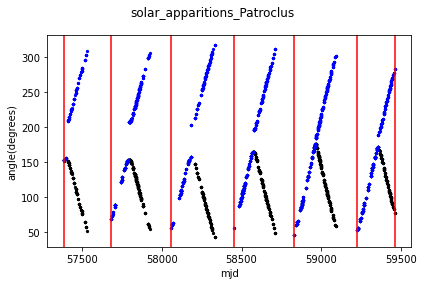

In [18]:
sol.plot_solar_elongation(epochs)

In [19]:
epochs_JPL = sol.solar_elongation_JPL(JPL_step="7d")
print(epochs_JPL)
N_app_JPL = len(epochs_JPL)-1 # number of apparitions detected in both filters
print(N_app_JPL)

query Horizons
[57384.475197 57594.       57993.       58385.       58770.
 59162.       59461.248218]
6


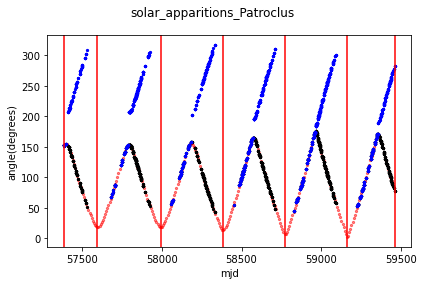

In [20]:
sol.plot_solar_elongation(epochs_JPL)

Text(0.5, 1.0, 'Patroclus')

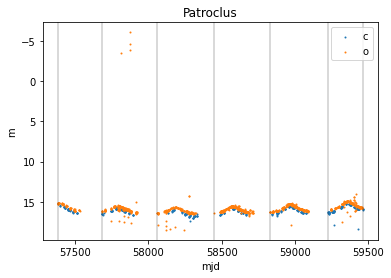

In [21]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data_filt[df_data_filt["filter"]=="c"]
df_plot2 = df_data_filt[df_data_filt["filter"]=="o"]

ax1.scatter(df_plot1["mjd"],df_plot1["m"],s=1, label = "c")
ax1.scatter(df_plot2["mjd"],df_plot2["m"],s=1, label = "o")

for x in epochs:
    ax1.axvline(x,c="k",alpha = 0.2)
    
# for x in epochs_JPL:
#     ax1.axvline(x,c="r")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("mjd")
ax1.set_ylabel("m")
ax1.set_title(name)

Text(0.5, 1.0, 'Patroclus')

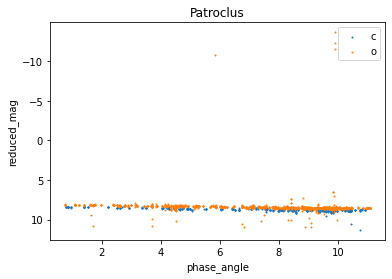

In [22]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data_filt[df_data_filt["filter"]=="c"]
df_plot2 = df_data_filt[df_data_filt["filter"]=="o"]

ax1.scatter(df_plot1["phase_angle"],df_plot1["reduced_mag"],s=1, label = "c")
ax1.scatter(df_plot2["phase_angle"],df_plot2["reduced_mag"],s=1, label = "o")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

# reject outlying data

In [23]:
list(df_data_filt)

['expname',
 'dec_deg',
 'ra_deg',
 'mjd',
 'm',
 'merr',
 'filter',
 'observer_distance',
 'heliocentric_distance',
 'phase_angle',
 'reduced_mag',
 'apparent_mag',
 'galactic_latitude',
 'sun_obs_target_angle',
 'orbfit_separation_arcsec']

In [24]:
orbfit_sep_cut = 1.0
mag_err_small = 0.005
gal_lat_cut = 10.0

# drop any nans
df_data = df_data_filt.dropna(subset=["mjd","reduced_mag","merr"])
print(len(df_data))
# drop large orbfit uncertainties
df_data = df_data[df_data["orbfit_separation_arcsec"]<=orbfit_sep_cut]
print(len(df_data))
# drop small (or zero) uncertainties
df_data = df_data[df_data["merr"]>=mag_err_small]
print(len(df_data))

# drop near galactic plane
df_data = df_data[np.absolute(df_data["galactic_latitude"])>=gal_lat_cut]
print(len(df_data))

# drop on mag5sig/limiting magnitude when possible


1709
1644
1642
1642


Text(0.5, 1.0, 'Patroclus')

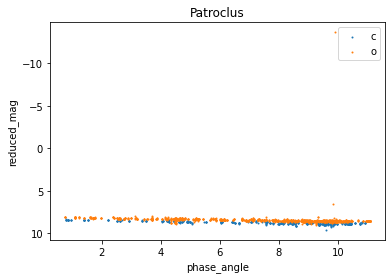

In [25]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data[df_data["filter"]=="c"]
df_plot2 = df_data[df_data["filter"]=="o"]

ax1.scatter(df_plot1["phase_angle"],df_plot1["reduced_mag"],s=1, label = "c")
ax1.scatter(df_plot2["phase_angle"],df_plot2["reduced_mag"],s=1, label = "o")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

Text(0.5, 1.0, 'Patroclus')

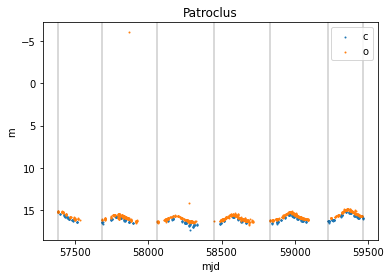

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data[df_data["filter"]=="c"]
df_plot2 = df_data[df_data["filter"]=="o"]

ax1.scatter(df_plot1["mjd"],df_plot1["m"],s=1, label = "c")
ax1.scatter(df_plot2["mjd"],df_plot2["m"],s=1, label = "o")

for x in epochs:
    ax1.axvline(x,c="k",alpha = 0.2)
    
# for x in epochs_JPL:
#     ax1.axvline(x,c="r")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("mjd")
ax1.set_ylabel("m")
ax1.set_title(name)

In [27]:
# sbpy phase curve models
# model_atlas = HG(H = H_B89_o * u.mag, G = G_B89_o)

# use the astorb H and G here? Our fits might be bad for strong apparition effects!
# model_atlas = HG(H = 13.48 * u.mag, G = 0.15)
model_atlas = HG(H = df_HG.iloc[0]["H_abs_mag_o"] * u.mag, G = df_HG.iloc[0]["G_slope"])

print(model_atlas)

Model: HG
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            H          G  
           mag            
    ----------------- ----
    7.898000000000001 0.15


Text(0.5, 1.0, 'Patroclus')

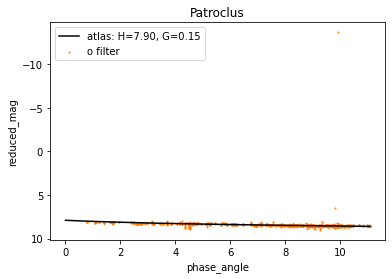

In [28]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot = df_data[df_data["filter"]=="o"]

ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1,c="C1", label = "o filter")

# evaluate the HG models
phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
reduced_mag_atlas = model_atlas(phase_angle)

ax1.plot(phase_angle,reduced_mag_atlas,c="k",
         label = "atlas: H={:.2f}, G={:.2f}".format(model_atlas.H.value,model_atlas.G.value))

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

# fit a simple HG curve to largest epoch using bootstrap

In [29]:
# HG_model = HG(H = H_B89_o * u.mag, G = 0.15) # use the astorb G if available
HG_model = HG(H = 13.48 * u.mag, G = 0.15)

# HG_model.G.fixed = True
fitter = LevMarLSQFitter()

print(HG_model)

Model: HG
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      H    G  
     mag      
    ----- ----
    13.48 0.15


In [30]:
HG_model.H.value

13.48

In [31]:
epochs

array([57384.475197  , 57681.5985394 , 58059.6453058 , 58449.65563545,
       58828.640451  , 59227.648125  , 59461.248218  ])

In [32]:
N_data_epoch = []
for i,x in enumerate(epochs[1:]):
    mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
    df = df_data[mask]
    N_data_epoch.append(len(df))
N_data_epoch

[66, 229, 173, 288, 281, 176]

In [33]:
epoch_max = np.argmax(N_data_epoch)
epoch_max,epochs[epoch_max], epochs[epoch_max+1]

(3, 58449.65563545, 58828.640451)

In [34]:
mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
df = df_data[mask]
print(len(df))

176


In [35]:
# select data at largest epoch
i = epoch_max
mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
df_max = df_data[mask]

[0.01204027 0.02125591]


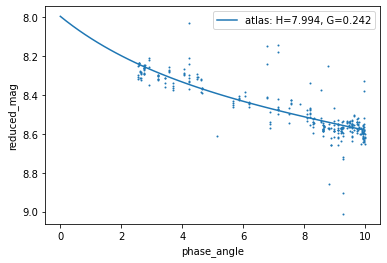

In [36]:
# do the first fit

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

alpha = np.array(df_max["phase_angle"]) * u.deg
mag = np.array(df_max["reduced_mag"]) * u.mag
mag_err = np.array(df_max["merr"]) * u.mag

model1 = fitter(HG_model, alpha, mag, weights=1.0/np.array(mag_err))
param_cov = fitter.fit_info['param_cov']
param_err_x = np.sqrt(np.diag(param_cov))
print(param_err_x)

df_plot = df_max


ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1)
phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
reduced_mag_atlas = model1(phase_angle)
ax1.plot(phase_angle,reduced_mag_atlas,
         label = "atlas: H={:.3f}, G={:.3f}".format(model1.H.value,model1.G.value))

ax1.legend()
ax1.invert_yaxis()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")

plt.show()

In [37]:
def bootstrap_fit(df, N = 100, frac = 1, plot = False):

    H_list = []
    G_list = []

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    for i in range(N):

    #     print(i)

        # resample with replacement
        _df = df.sample(frac = frac, replace = True)  
    #     print(_df)    
        alpha = np.array(_df["phase_angle"]) * u.deg
        mag = np.array(_df["reduced_mag"]) * u.mag
        mag_err = np.array(_df["merr"]) * u.mag

        model = fitter(HG_model, alpha, mag, weights=1.0/np.array(mag_err))

        H_list.append(model.H.value)
        G_list.append(model.G.value)

        df_plot = _df

        ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1)
        phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
        reduced_mag_atlas = model(phase_angle)
        ax1.plot(phase_angle,reduced_mag_atlas,
                 label = "atlas: H={:.2f}, G={:.2f}".format(model.H.value,model.G.value))

    H_list = np.array(H_list)
    G_list = np.array(G_list)

    ax1.invert_yaxis()
    ax1.set_xlabel("phase_angle")
    ax1.set_ylabel("reduced_mag")
    
    if plot:
        plt.show()
    else:
        plt.close()
    
    return H_list, G_list

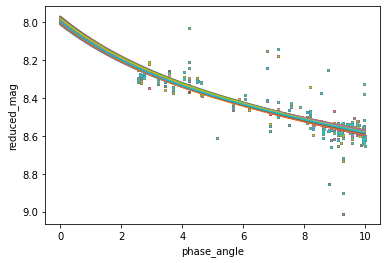

In [38]:
H_list, G_list = bootstrap_fit(df_max, plot = True)

In [39]:
def gauss_fit(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [40]:
def fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = False):

    fig = plt.figure()
    gs = gridspec.GridSpec(1,2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    
    coeff_list = []

    for data, ax in zip(data_list,[ax1,ax2]):

        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., np.median(data), np.ptp(data)/2.0]

        hist, bin_edges = np.histogram(data, density=True, bins = bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

        coeff, var_matrix = curve_fit(gauss_fit, bin_centres, hist, p0=p0)
        coeff_list.append(coeff)

        # Get the fitted curve
        x_grid = np.linspace(np.amin(bin_centres), np.amax(bin_centres), 100)
        hist_fit = gauss_fit(x_grid, *coeff)
        ax.plot(x_grid,hist_fit, label = "mu = {:.3f}, sig = {:.3f}".format(coeff[1],coeff[2]))
        ax.axvline(coeff[1])
        ax.axvline(coeff[1]+coeff[2])
        ax.axvline(coeff[1]-coeff[2])

        ax.hist(data, bins=bins, histtype="step", density = True, color = "k")
        ax.bar(x=bin_centres, height=hist, width=np.diff(bin_edges))

        ax.legend()

    ax1.set_xlabel("H")
    ax1.set_ylabel("density")
    ax2.set_xlabel("G")
    ax2.set_ylabel("density")

    plt.tight_layout()
    
    if plot:
        plt.show()
    else:
        plt.close()
    
    return coeff_list

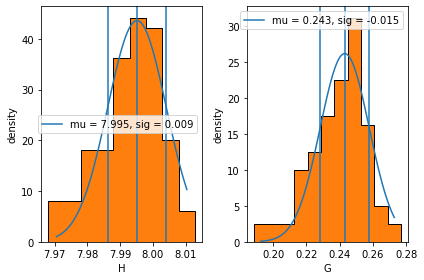

[array([4.36193003e+01, 7.99513814e+00, 8.96040121e-03]),
 array([ 2.61946958e+01,  2.42992254e-01, -1.47252644e-02])]

In [41]:
fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = True)

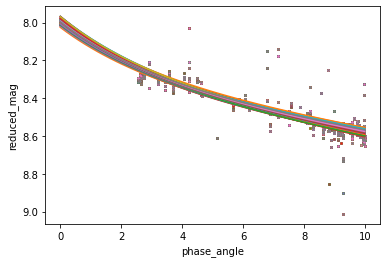

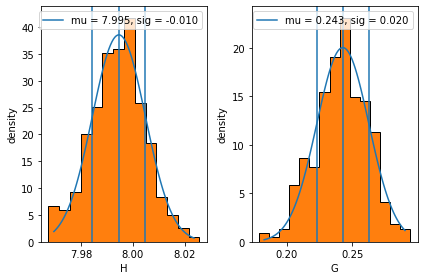

In [42]:
H_list, G_list = bootstrap_fit(df_max, N = len(df_max), plot = True)
fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = True)

H_std = np.std(H_list)
G_std = np.std(G_list)

In [43]:
# # modify the number of bootstraps
# N_list = [10,50,100,200,400,600,800,1000]#, 1500, 2000, 3000, 4000, 5000, 7500, 10000, 20000, 30000, 50000]

# fig = plt.figure()
# gs = gridspec.GridSpec(2,2)
# ax1 = plt.subplot(gs[0,0])
# ax2 = plt.subplot(gs[0,1])
# ax3 = plt.subplot(gs[1,0])
# ax4 = plt.subplot(gs[1,1])

# for N in N_list:
#     print(N)
#     H_list, G_list = bootstrap_fit(df_max, N = N)
#     coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")
    
#     # plot the mean H and G 
#     ax1.scatter(N,coeffs[0][1], c = "C0")
#     ax3.scatter(N,coeffs[1][1], c = "C0")
    
#     # plot the sigma H and G
#     ax2.scatter(N,np.absolute(coeffs[0][2]), c = "C1")
#     ax4.scatter(N,np.absolute(coeffs[1][2]), c = "C1")
    
# ax1.set_xlabel("N")
# ax1.set_ylabel("mean")
# ax2.set_xlabel("N")
# ax2.set_ylabel("sigma")
# ax3.set_xlabel("N")
# ax3.set_ylabel("mean")
# ax4.set_xlabel("N")
# ax4.set_ylabel("sigma")

# plt.tight_layout()
# plt.show()

In [44]:
# # modify the sample fraction
# N = 100
# frac_list = [1.0,0.9,0.8,0.6,0.5]

# fig = plt.figure()
# gs = gridspec.GridSpec(2,2)
# ax1 = plt.subplot(gs[0,0])
# ax2 = plt.subplot(gs[0,1])
# ax3 = plt.subplot(gs[1,0])
# ax4 = plt.subplot(gs[1,1])

# for f in frac_list:
#     print(N, f)
#     H_list, G_list = bootstrap_fit(df_max, N = N, frac = f)
#     coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")
    
#     # plot the mean H and G 
#     ax1.scatter(f,coeffs[0][1], c = "C0")
#     ax3.scatter(f,coeffs[1][1], c = "C0")
    
#     # plot the sigma H and G
#     ax2.scatter(f,np.absolute(coeffs[0][2]), c = "C1")
#     ax4.scatter(f,np.absolute(coeffs[1][2]), c = "C1")
    
# ax1.set_xlabel("frac")
# ax1.set_ylabel("mean")
# ax2.set_xlabel("frac")
# ax2.set_ylabel("sigma")
# ax3.set_xlabel("v")
# ax3.set_ylabel("mean")
# ax4.set_xlabel("frac")
# ax4.set_ylabel("sigma")

# plt.tight_layout()
# plt.show()

In [45]:
# # modify the number of bootstraps
# N_list = [100,200,300,400,500]
# # frac_list = [1.0,0.9,0.8,0.7]
# # N_list = [100,300,500,700,900,1000]
# frac_list = [1.0]
# N_repeat = 3

# # N_list = [500,1000,1500,2000]
# # frac_list = [1.0]
# # N_repeat = 1

# fig = plt.figure()
# gs = gridspec.GridSpec(2,2)
# ax1 = plt.subplot(gs[0,0])
# ax2 = plt.subplot(gs[0,1])
# ax3 = plt.subplot(gs[1,0])
# ax4 = plt.subplot(gs[1,1])

# for j in range(N_repeat):
#     print(j)
#     for i,f in enumerate(frac_list):
#         for N in N_list:
#             print(N,f)

#     #         coeffs = []
#     #         while len(coeffs)==0:
#     #             H_list, G_list = bootstrap_fit(df, N = N, frac = f)
#     #             try:
#     #                 coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")
#     #             except:
#     #                 continue

#             H_list, G_list = bootstrap_fit(df_max, N = N, frac = f)#, plot = True)
        
# #             coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")#, plot = True)
# #             H_mu = coeffs[0][1]
# #             G_mu = coeffs[1][1]
# #             H_std = np.absolute(coeffs[0][2])
# #             G_std = np.absolute(coeffs[1][2])
    
#             H_mu = np.mean(H_list)
#             G_mu = np.mean(G_list)
#             H_std = np.std(H_list)
#             G_std = np.std(G_list)
            
#             # plot the mean H and G 
#             ax1.scatter(N,H_mu, c = "C{}".format(i))
#             ax3.scatter(N,G_mu, c = "C{}".format(i))

#             # plot the sigma H and G
#             ax2.scatter(N,H_std, c = "C{}".format(i))
#             ax4.scatter(N,G_std, c = "C{}".format(i))

# # plot the first fit
# ax1.axhline(model1.H.value)
# ax3.axhline(model1.G.value)
# # indicate the std from the last bootstrap
# ax1.axhspan(model1.H.value+H_std, model1.H.value-H_std, alpha=0.5, color = "r")
# ax3.axhspan(model1.G.value+G_std, model1.G.value-G_std, alpha=0.5, color = "r")

# ax1.set_xlabel("N")
# ax1.set_ylabel("H_mean")
# ax2.set_xlabel("N")
# ax2.set_ylabel("H_std")
# ax3.set_xlabel("N")
# ax3.set_ylabel("G_mean")
# ax4.set_xlabel("N")
# ax4.set_ylabel("G_std")

# plt.tight_layout()
# plt.show()

# fit H, but not G, to every other epoch

In [46]:
# values and errors from LSQ fitter
print("H = {} +/- {}".format(model1.H.value,param_err_x[0]))
print("G = {} +/- {}".format(model1.G.value,param_err_x[1]))

H = 7.994360660849656 +/- 0.012040272832129781
G = 0.2418224927060033 +/- 0.021255908699157607


In [47]:
print(len(df_max))

288


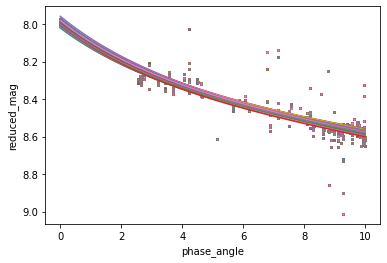

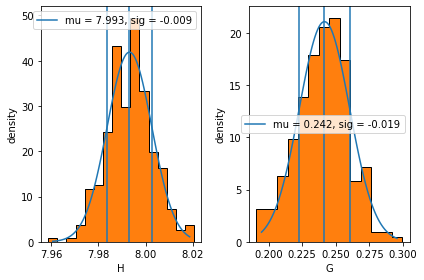

H = 7.993234130739101 +/- 0.009844850247241809
G = 0.2401652180788042 +/- 0.01887708038588604
H = 7.993813711635505 +/- 0.009844850247241809
G = 0.24121642016889394 +/- 0.01887708038588604


In [48]:
H_list, G_list = bootstrap_fit(df_max, N = len(df_max), plot = True)
coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = True)
# print(coeffs[0][2],coeffs[1][2])

H_mean = np.mean(H_list)
G_mean = np.mean(G_list)
H_med = np.median(H_list)
G_med = np.median(G_list)
H_std = np.std(H_list)
G_std = np.std(G_list)

# values and errors from bootstrap
print("H = {} +/- {}".format(H_mean,H_std))
print("G = {} +/- {}".format(G_mean,G_std))
print("H = {} +/- {}".format(H_med,H_std))
print("G = {} +/- {}".format(G_med,G_std))

In [49]:
# values from initial fit and errors from bootstrap
print("H = {} +/- {}".format(model1.H.value,H_std))
print("G = {} +/- {}".format(model1.G.value,G_std))

H = 7.994360660849656 +/- 0.009844850247241809
G = 0.2418224927060033 +/- 0.01887708038588604


In [50]:
HG_model_fixed = HG(H = model1.H.value * u.mag, G = model1.G.value)
HG_model_fixed.G.fixed = True
fitter = LevMarLSQFitter()

In [51]:
params = HG_model_fixed.param_names
params

('H', 'G')

<IPython.core.display.Javascript object>


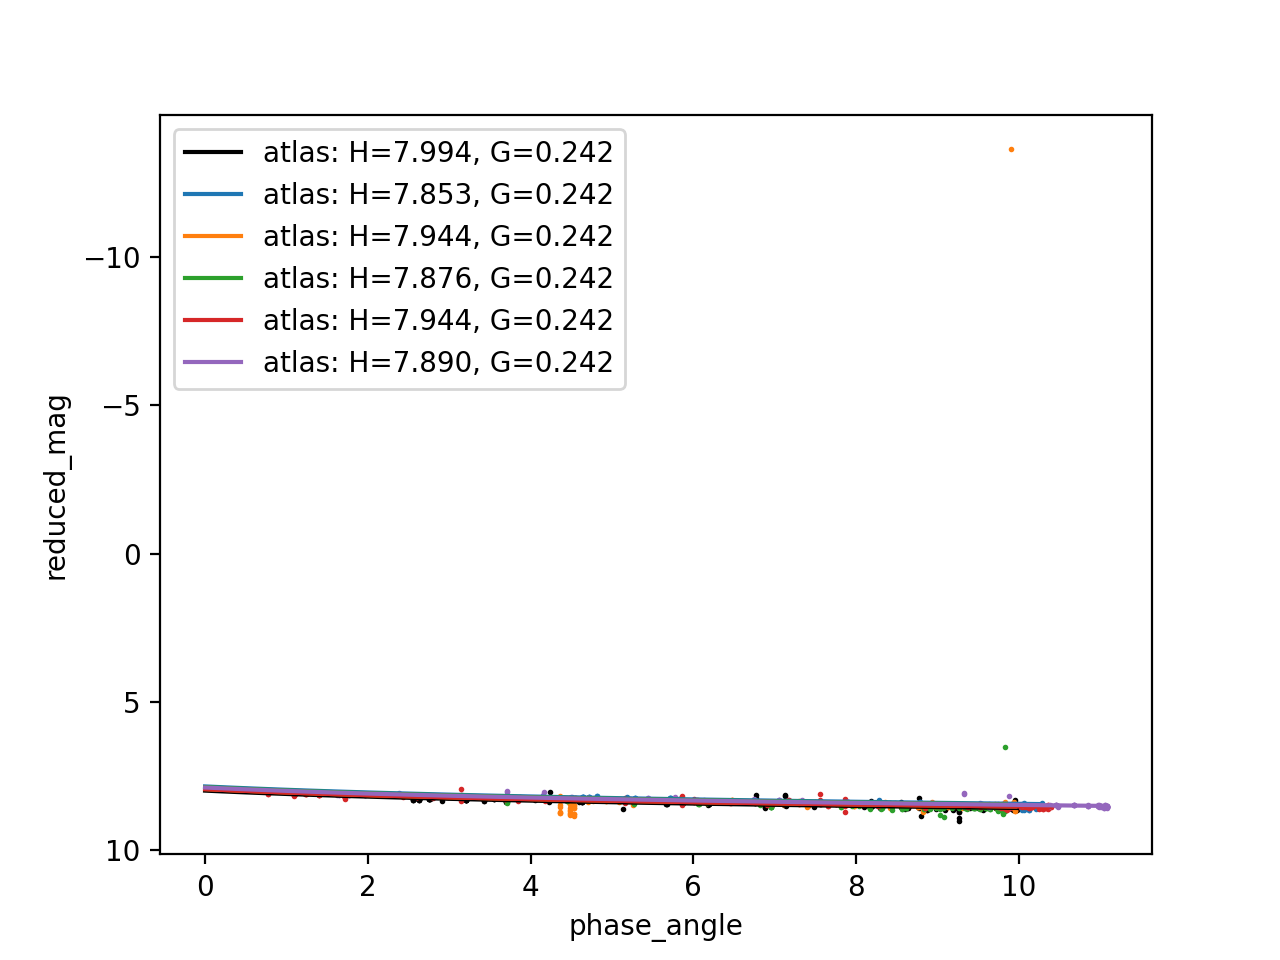

66
229
173
281
176


In [54]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])
    
# plot the first fit
df_plot = df_max
ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1,c="k")
phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
reduced_mag_atlas = model1(phase_angle)
ax1.plot(phase_angle,reduced_mag_atlas,
         label = "atlas: H={:.3f}, G={:.3f}".format(model1.H.value,model1.G.value),c="k")
    
for i,x in enumerate(epochs[1:]):
    
    if i==epoch_max:
        continue
        
    mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
    df = df_data[mask]
    print(len(df))
    
    # or add a min number of data points to fit here
    if len(df)<len(params):
        continue
    
    alpha = np.array(df["phase_angle"]) * u.deg
    mag = np.array(df["reduced_mag"]) * u.mag
    mag_err = np.array(df["merr"]) * u.mag

    model = fitter(HG_model_fixed, alpha, mag, weights=1.0/np.array(mag_err))



    df_plot = df

    ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1)
    phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
    reduced_mag_atlas = model(phase_angle)
    ax1.plot(phase_angle,reduced_mag_atlas,
             label = "atlas: H={:.3f}, G={:.3f}".format(model.H.value,model.G.value))

ax1.legend()
ax1.invert_yaxis()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")

plt.show()


Get G from the epoch with the most data.
Quote the brightest H value for final absolute mag? Poorly sampled epochs could throw this off

How to fit c filter data? Keep G fixed?